# Recurrent Neural Networks for Time Series Forecasting: LTSM (Darts Package)

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd


import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter()

from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, Theta
from darts.metrics import mse, mape, rmse, mase, smape, mae
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries

from DataExploration.BitbrainsUtils import load_VM
from darts import TimeSeries


import sys
import time
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

# Prepare the Source Data

In [2]:
# Load data
VM = load_VM('917.csv')
series = TimeSeries.from_dataframe(VM, value_cols='CPU usage [MHZ]', freq='5T')
ts = series

In [3]:
# replace 0 and NaN by backfilling
s = series.pd_series()
s.replace(0.0, np.nan, inplace=True)
s = s.fillna(method="bfill")
series = series.from_series(s)
ts = series

## Data exploration

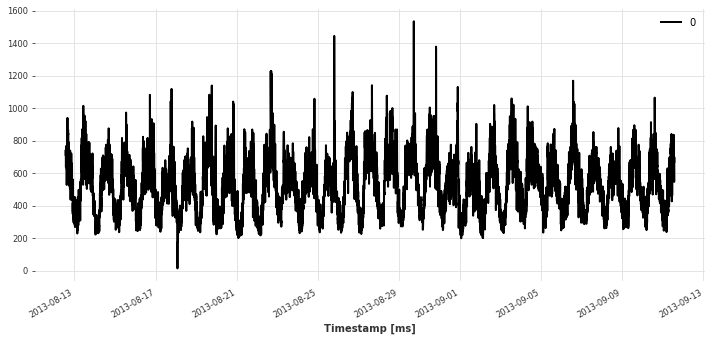

In [4]:
import matplotlib
# matplotlib.use('TkAgg')
# matplotlib.use('MacOSX')
# plot the observations
plt.figure(figsize=(12, 5))
ts.plot()
plt.show()

In [5]:
# analyze its seasonality
is_seasonal, periodicity = check_seasonality(series, max_lag=300)
dict_seas ={
    "is seasonal?":is_seasonal, 
    "periodicity (Timestamps)":f'{periodicity:.1f}',
    "periodicity (~Hours)": f'{periodicity*5/60:.1f}'}
_ = [print(k,":",v) for k,v in dict_seas.items()]

is seasonal? : True
periodicity (Timestamps) : 286.0
periodicity (~Hours) : 23.8


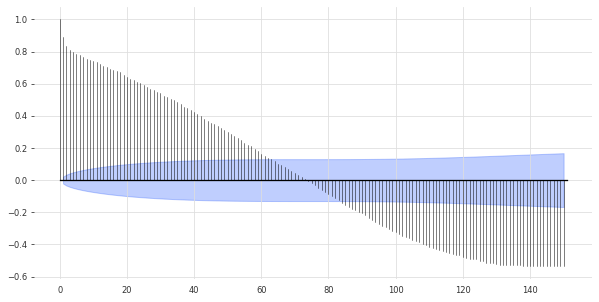

In [6]:
# plot its autocorrelation function
plot_acf(series, max_lag=150)

## Data preprocessing

In [7]:
# split training vs test dataset
FC_SPLIT = 0.9          # period at which to split training and validation dataset
train, val = ts.split_after(FC_SPLIT)

In [8]:
# normalize the time series
trf = Scaler()
# fit the transformer to the training dataset
train_trf = trf.fit_transform(train)
# apply the transformer to the validation set and the complete series 
val_trf = trf.transform(val)
ts_trf = trf.transform(ts)

In [9]:
# create day and hours covariate series
day_series = datetime_attribute_timeseries(
    pd.date_range(start=series.start_time(), 
        freq=ts.freq_str, 
        periods=len(ts)),
    attribute='day',
    one_hot=False)
day_series = Scaler().fit_transform(day_series)

hour_series = datetime_attribute_timeseries(
    day_series,
    attribute='hour',
    one_hot=True)

covariates = day_series.stack(hour_series)
cov_train, cov_val = covariates.split_after(FC_SPLIT)

## Modeling

In [40]:
# Hyper-parameters
EPOCH = 50
MODEL = 'LSTM'
INPUT_CHUNK_LENGTH = 288
FORECASTING_HORIZON = 288*3
HIDDEN_DIM = 20
N_LAYERS = 1
DROPOUT = 0
LR = 1e-3

In [41]:
 # set the model up
LTSM_model = RNNModel(
    model=MODEL,
    model_name=MODEL,
    input_chunk_length=INPUT_CHUNK_LENGTH,
    training_length=INPUT_CHUNK_LENGTH,
    hidden_dim=HIDDEN_DIM,
    n_rnn_layers=N_LAYERS,
    batch_size=16,
    n_epochs=EPOCH,
    dropout=DROPOUT,
    optimizer_kwargs={'lr': LR},
    nr_epochs_val_period=1,
    log_tensorboard=True,
    random_state=42,
    force_reset=True,
    save_checkpoints=True)

In [ ]:
# Fit the model
t_start =  time.perf_counter()
print("\nbeginning the training")
res = LTSM_model.fit(
         train_trf,
         future_covariates=covariates,
         val_series=val_trf,
         val_future_covariates=covariates,
         verbose=True)
res_time = time.perf_counter() - t_start
print("Training has completed:", f'{res_time:.2f} sec')


beginning the training


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

### Look at predictions at the validation set

Predicting: 468it [00:00, ?it/s]

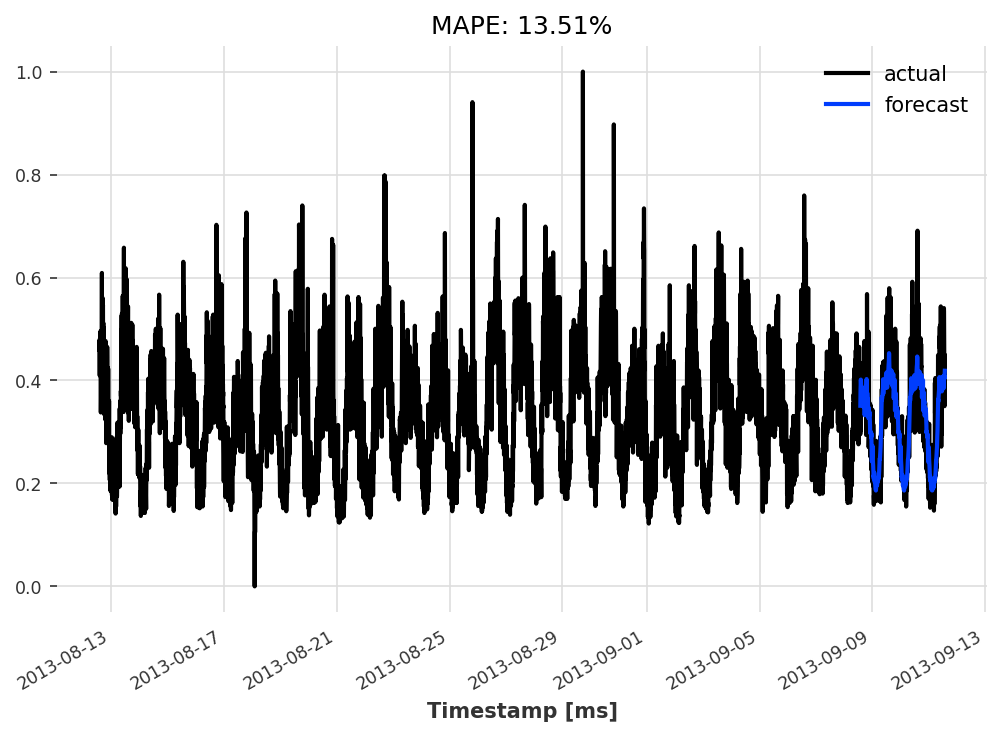

In [35]:
def eval_model(model):
    pred_series = model.predict(n=FORECASTING_HORIZON, future_covariates=covariates)
    plt.figure(figsize=(8, 5), dpi=150)
    ts_trf.plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title("MAPE: {:.2f}%".format(mape(pred_series, val_trf)))
    plt.legend()

    # Metrics
    res_mape = mape(val_trf, pred_series)
    res_mae = mae(val_trf, pred_series)
    res_mse = mse(val_trf, pred_series)
    res_rmse = rmse(val_trf, pred_series)
    res_smape = smape(val_trf, pred_series)
    res_mase = mase(val_trf, pred_series,train_trf)
    res_accuracy = {"MAPE":res_mape, "MASE":res_mase, "MAE":res_mae, "RMSE":res_rmse, "MSE":res_mse,"SMAPE": res_smape, "time":res_time}

    results = [pred_series, res_accuracy]
    return results

%matplotlib inline
model_predictions = eval_model(LTSM_model)

In [39]:
metrics = pd.DataFrame.from_dict(model_predictions[1], orient='index')
metrics

,0
MAPE,12.662795
MASE,1.074328
MAE,0.041463
RMSE,0.054003
MSE,0.002916
SMAPE,12.889368
time,126.517570


Predicting: 0it [00:00, ?it/s]

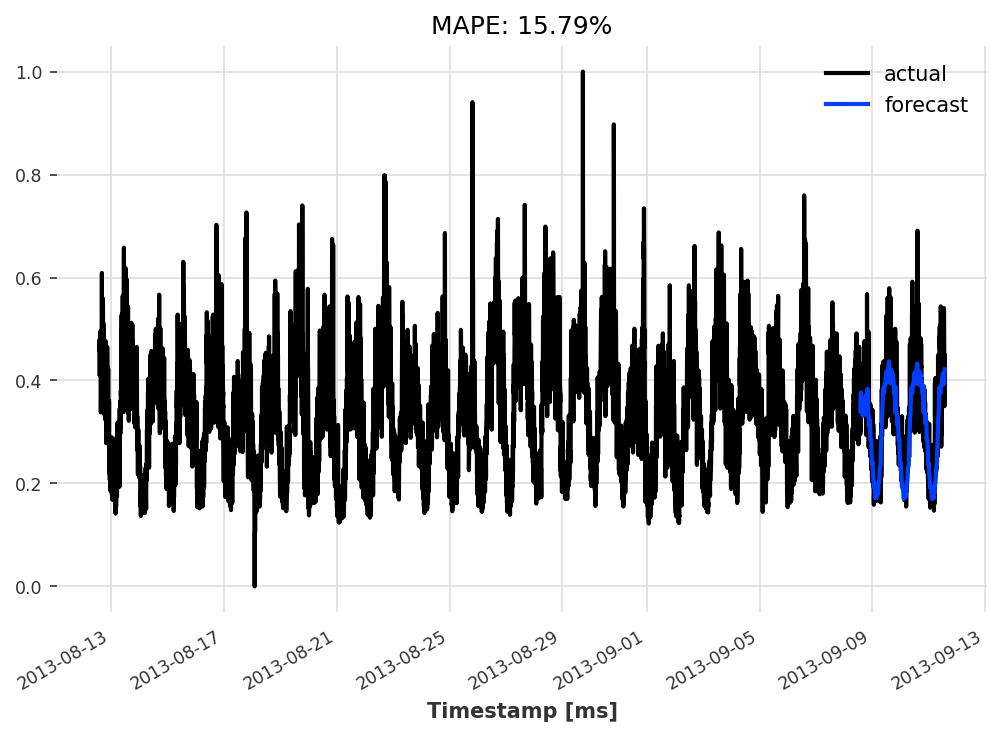

In [25]:
# Take best model
best_model = RNNModel.load_from_checkpoint(model_name="LSTM", best=True)
eval_model(best_model)

### Backtesting

In [ ]:
backtest_series = LTSM_model.historical_forecasts(
    ts_trf,
    future_covariates=covariates,
    start=0.8,
    forecast_horizon=288*3,
    retrain=False,
    verbose=False,
)

MAPE: 13.12%


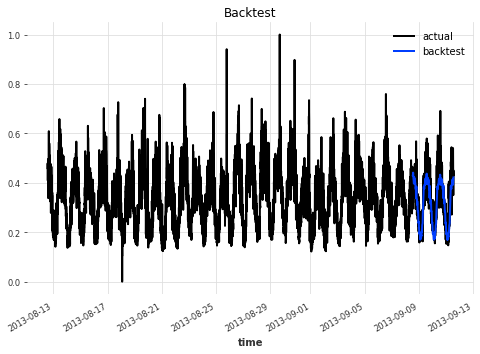

In [28]:
plt.figure(figsize=(8, 5))
ts_trf.plot(label="actual")
backtest_series.plot(label="backtest")
plt.legend()
plt.title("Backtest")
print(
    "MAPE: {:.2f}%".format(
        mape(
            trf.inverse_transform(ts_trf),
            trf.inverse_transform(backtest_series),
        )
    )
)

In [26]:
# helper function: fit the RNN model

def fit_it(model, train, val, flavor):
    t_start =  time.perf_counter()
    print("\nbeginning the training of the {0} RNN:".format(flavor))

    res = model.fit(train,
             future_covariates=covariates,
             val_series=val,
             val_future_covariates=covariates,
             verbose=True)

    res_time = time.perf_counter() - t_start
    print("training of the {0} RNN has completed:".format(flavor), f'{res_time:.2f} sec')

    return res

In [27]:
# helper function: plot the predictions

def plot_fitted(pred, act, flavor):
    plt.figure(figsize=(12,5))
    act.plot(label='actual')
    pred.plot(label='prediction')
    plt.title("RNN: {0} flavor".format(flavor) + ' | MAPE: {:.2f}%'.format(mape(pred, act)))
    plt.legend();

In [28]:
# helper function: compute accuracy metrics
   
def accuracy_metrics(pred, act):
    act2 = act.slice_intersect(pred)
    pred2 = pred.slice_intersect(act2)
    resid = pred2 - act2
    sr = resid.pd_series()
    sa = act2.pd_series()
    sp = pred2.pd_series()
    res_mape = mape(pred2, act2)
    res_r2 = r2_score(pred2, act2)
    res_rmse = rmse(pred2, act2)
    res_pe = sr / sa
    n_act = len(act2)
    res_rmspe = np.sqrt(np.sum(res_pe**2) / n_act)    # root mean square percentage error
    res_std = np.std(sr)                               # std error of the model = std deviation of the noise
    res_se = res_std / np.sqrt(n_act)                  # std error in estimating the mean
    res_sefc = np.sqrt(res_std + res_se**2)            # std error of the forecast
    
    res_accuracy = {
        "MAPE":res_mape,"RMSPE":res_rmspe, "RMSE":res_rmse, 
        "-R squared":-res_r2, "se": res_sefc}
    return res_accuracy

In [29]:
# set up, fit, run, plot, and evaluate the RNN model

def run_RNN(flavor, ts, train, val):

    # set the model up
    model_RNN = RNNModel(
        model=flavor,
        model_name=flavor + str(" RNN"),
        input_chunk_length=288,
        training_length=288,
        hidden_dim=20,
        batch_size=16,
        n_epochs=EPOCH,
        dropout=0,
        optimizer_kwargs={'lr': 1e-3},
        log_tensorboard=True,
        random_state=42,
        force_reset=True)
        
    if flavor == "RNN": flavor = "Vanilla" 

    # fit the model
    fit_it(model_RNN, train, val, flavor)

    # compute N predictions
    pred = model_RNN.predict(n=FC_N, future_covariates=covariates)
    # pred = model_RNN.predict(n=50) # Custom

    # plot predictions vs actual
    plot_fitted(pred, ts, flavor)

    # print accuracy metrics
    res_acc = accuracy_metrics(pred, ts)    
    print(flavor + " : ")
    _ = [print(k,":",f'{v:.4f}') for k,v in res_acc.items()]

    return [pred, res_acc]
    


beginning the training of the LSTM RNN:


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

training of the LSTM RNN has completed: 93.89 sec


Predicting: 468it [00:00, ?it/s]

LSTM : 
MAPE : 13.9250
RMSPE : 0.1584
RMSE : 0.0531
-R squared : -0.5862
se : 0.2258


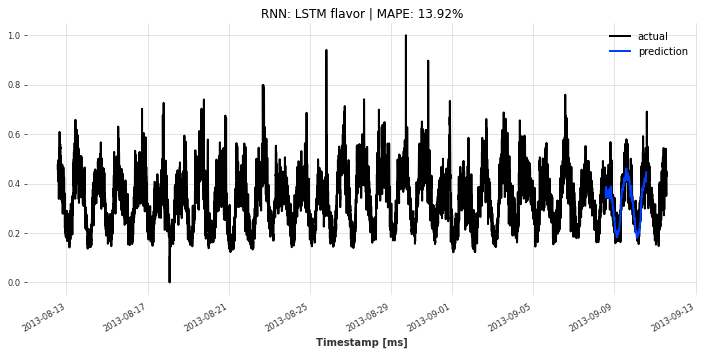

In [30]:
# run 3 different flavors of RNN on the time series:
# flavors = ["LSTM", "GRU", "RNN"]
flavors = ['LSTM']

# call the RNN model setup for each of the 3 RNN flavors
res_flavors = [run_RNN(flv, ts_trf, train_trf, val_trf) for flv in flavors]


beginning the training of the LSTM RNN:


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

training of the LSTM RNN has completed: 61.32 sec


Predicting: 468it [00:00, ?it/s]

LSTM : 
MAPE : 13.9250
RMSPE : 0.1584
RMSE : 0.0531
-R squared : -0.5862
se : 0.2258


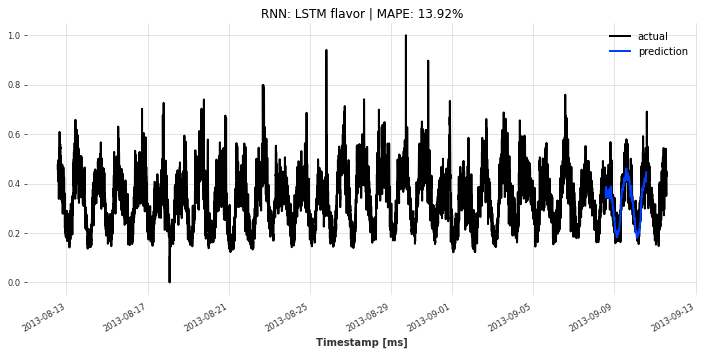

In [31]:
# set the model up
flavor = 'LSTM'
ts = ts_trf
train = train_trf
val = val_trf
model_RNN = RNNModel(
    model=flavor,
    model_name=flavor + str(" RNN"),
    input_chunk_length=288,
    training_length=288,
    hidden_dim=20,
    batch_size=16,
    n_epochs=EPOCH,
    dropout=0,
    optimizer_kwargs={'lr': 1e-3},
    log_tensorboard=True,
    random_state=42,
    force_reset=True)

# fit the model
res = fit_it(model_RNN, train, val, flavor)

# compute N predictions
pred = model_RNN.predict(n=FC_N, future_covariates=covariates)
# pred = model_RNN.predict(n=50) # Custom

# plot predictions vs actual
plot_fitted(pred, ts, flavor)

# print accuracy metrics
res_acc = accuracy_metrics(pred, ts)
print(flavor + " : ")
_ = [print(k,":",f'{v:.4f}') for k,v in res_acc.items()]


# Compare with the Theta method

Theta forecast has completed:  4.45 sec
MAPE : 16.1069
RMSPE : 0.1938
RMSE : 100.1816
-R squared : -0.4182
se : 10.2523


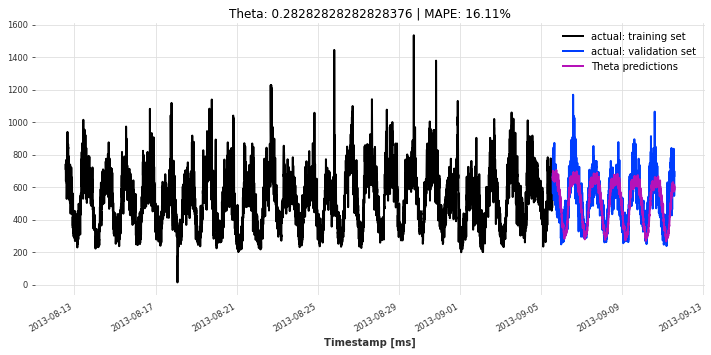

In [19]:
# Theta forecaster

# search space for best theta value: check 100 alternatives
thetas = 2 - np.linspace(-10, 10, 100)

# initialize search
best_mape = float('inf')
best_theta = 0
t_start =  time.perf_counter()
# search for best theta among 100 values, as measured by MAPE
for theta in thetas:
    model = Theta(theta)
    res = model.fit(train)
    pred_theta = model.predict(len(val))
    res_mape = mape(val, pred_theta)
    if res_mape < best_mape:
        best_mape = res_mape
        best_theta = theta


# fit the model
best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred = best_theta_model.predict(len(val))

# review the Theta results
plt.figure(figsize=(12,5))
train.plot(label='actual: training set')
val.plot(label='actual: validation set')
pred.plot(label='Theta predictions')
plt.title("Theta: {0}".format(best_theta) + ' | MAPE: {:.2f}%'.format(mape(pred, val)))
plt.legend();

res_time = time.perf_counter() - t_start
res_acc = accuracy_metrics(pred, val)
print("Theta forecast has completed: ", f'{res_time:.2f} sec')
_ = [print(k,":",f'{v:.4f}') for k,v in res_acc.items()]
results = [pred, res_acc]


In [20]:
# collect the forecasters's accuracy metrics in a dataframe

dict_models = {"LSTM":res_flavors[0][1], "GRU":res_flavors[1][1],
    "Vanilla":res_flavors[2][1], "Theta":res_acc}
df_acc = pd.DataFrame.from_dict(dict_models, orient="index").T
pd.set_option("display.precision",3)
df_acc.style.highlight_min(color="lightgreen", axis=1).highlight_max(color="yellow", axis=1)

IndexError: list index out of range